# Case study demonstrating the Energy Resilience and Performance tool

## Initialization

In [20]:
import pandas as pd
import numpy as np
import json
import requests
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from src.post_and_poll import get_api_results
API_KEY = '30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3'  # REPLACE WITH YOUR API KEY
root_url = "https://developer.nrel.gov/api/reopt/dev"
reopt_results_url = root_url + '/job/{run_uuid}/results/?api_key=' + API_KEY
# erp_url = root_url + '/erp/'
# erp_results_url = erp_url + '{run_uuid}/results/?api_key=' + API_KEY



In [21]:
# the following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

In [22]:
"""
Here are some convenience definitions for using the Multi-scenario capabilities
"""
##############################################################################################################
inputs_path = os.path.join(".", 'inputs')
outputs_path = os.path.join(".", 'outputs')
loads_path = os.path.join(".", 'load_profiles')
rates_path = os.path.join(".", 'electric_rates')
##############################################################################################################

## Helper functions

In [39]:
def summarize_reopt_results(reopt_post, reopt_response):
    print("LCC ($) = ", reopt_response["outputs"]["Financial"]["lcc"])
    print("Capital Cost, Net ($) = ", reopt_response["outputs"]["Financial"]["lifecycle_capital_costs"])
    tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage", "ColdThermalStorage", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine"]
    for tech in tech_list:
        if tech in reopt_post.keys():
            if tech == "GHP":
                print("GHX Number of Boreholes = ", reopt_response["outputs"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
                print("GHP Heat Pump Capacity (ton) = ", reopt_response["outputs"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
            # PV and Storage are considered if the POST does not explicitly make max_[size] == 0
            for size_name_value in [(key, val) for key, val in reopt_response["outputs"][tech].items() if "size" in key]:
                    print(tech + " " + size_name_value[0], " = ", size_name_value[1])
        elif tech in ["PV", "ElectricStorage"]:
            for size_name_value in [(key, val) for key, val in reopt_response["outputs"][tech].items() if "size" in key]:
                    print(tech + " " + size_name_value[0], " = ", size_name_value[1])

## POST inputs and GET results from the REopt API

### REopt Inputs

In [26]:
# Peak load occurs on 9/28
# Model 96 hour outage during 9/26-29
outage_start = 269*24+1
outage_duration = 96

reopt_post_initial = {
    "Settings": {
        "run_bau": False
    },
    "Site": {
        #San Fransisco
        "latitude": 37.77,
        "longitude": -122.42
    },
    "ElectricLoad": {
        "doe_reference_name": "LargeOffice", # annual 6085402.508 kwh, max 1663.026 kw
        "annual_kwh": 6085402.508,#*1.2, #makes peak load ~2MW
        "critical_load_percent": 0.5
    },  
    "ElectricTariff": {
        "urdb_label": "62d5b7fc4939f52c862151f9"
    },
    "ElectricUtility": {
        "outage_start_time_steps": [
            1084,
            3459,
            4395,
            6483
        ],
        "outage_durations": 24
    },
    "Generator": {
        "max_kw": 1e7
    },  
    "PV": {
        "max_kw": 1e7
    },    
    "ElectricStorage": {
        "max_kwh": 1e7,
        "max_kw": 1e7
    }    
}

### Run REopt to get optimal tech sizes

`get_api_results` POST's your inputs to the API `job` endpoint, which provides a `run_uuid` if the input is valid, and then polls the `results` endpoint using the `run_uuid` until the results come back with a status other than `Optimizing...`.

`get_api_results` also saves the results (full API response, including inputs) to the `results_file`.

A log file is also created in the current working directory.

In [27]:
reopt_initial_outputs_file_name = "erp_tag5_reopt_results_inital"
reopt_initial_outputs = get_api_results(post=reopt_post_initial, 
                               API_KEY=API_KEY, 
                               api_url=root_url, 
                               results_file=os.path.join(
                                   outputs_path, 
                                   reopt_initial_outputs_file_name+".json"
                               ), 
                               run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/dev/job/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling https://developer.nrel.gov/api/reopt/dev/job/80d96b30-2e6c-485d-aa7a-f50983b2af3c/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag5_reopt_results_inital.json


### If you get disconnected from the polling function but you think it ran, copy the run_uuid from the log above to manually GET the results:

In [ ]:
run_uuid = ""
resp = requests.get(url=reopt_results_url.format(run_uuid=run_uuid), verify=False)
reopt_initial_outputs = json.loads(resp.text)

### Summarize inital REopt optimization results

In [41]:
with open(os.path.join(outputs_path, reopt_initial_outputs_file_name + '.json'), 'rb') as handle:
    reopt_initial_outputs = json.load(handle)
    summarize_reopt_results(reopt_post_initial, reopt_initial_outputs)

LCC ($) =  12275584.0346
Capital Cost, Net ($) =  6048744.9186
PV size_kw  =  4049.6685
ElectricStorage size_kw  =  1001.21
ElectricStorage size_kwh  =  7418.92
Generator size_kw  =  0.0


## Run the ERP tool with REopt results and inputs

### ERP inputs

In [29]:
post_erp_opt_techs = {
    "reopt_run_uuid": reopt_initial_outputs["run_uuid"]    
}
post_erp_add_gen = post_erp_opt_techs.copy()
post_erp_add_gen["Generator"] = {
    "num_generators": 2,
    "size_kw" : 1600
}

### POST inputs and GET results from ERP API

In [30]:
erp_opt_techs_outputs_file_name = "erp_tag5_erp_results_opt_techs"
erp_opt_techs_outputs = get_api_results(post=post_erp_opt_techs, 
                                API_KEY=API_KEY, 
                                api_url=root_url, 
                                results_file=os.path.join(
                                   outputs_path, 
                                   erp_opt_techs_outputs_file_name+".json"
                                ), 
                                run_id=None,
                                ERP=True)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/dev/erp/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling https://developer.nrel.gov/api/reopt/dev/erp/31cfb2d0-f38f-4bd7-b364-1b8e5f25bdcb/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag5_erp_results_opt_techs.json


In [31]:
erp_add_gen_outputs_file_name = "erp_tag5_erp_results_add_gen"
erp_add_gen_outputs = get_api_results(post=post_erp_add_gen, 
                                API_KEY=API_KEY, 
                                api_url=root_url, 
                                results_file=os.path.join(
                                   outputs_path, 
                                   erp_add_gen_outputs_file_name+".json"
                                ), 
                                run_id=None,
                                ERP=True)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/dev/erp/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling https://developer.nrel.gov/api/reopt/dev/erp/0d42790a-0b79-4c61-8a6b-a33e1b5869ee/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag5_erp_results_add_gen.json


## Plot ERP results

### Optimal techs

In [32]:
cum_survival = erp_opt_techs_outputs["outputs"]["mean_cumulative_survival_by_duration"]
final_survival_by_start = erp_opt_techs_outputs["outputs"]["cumulative_survival_final_time_step"]
max_duration = len(cum_survival)
outage_durations = range(1, max_duration + 1)

### Plot cumulative survival vs outage duration

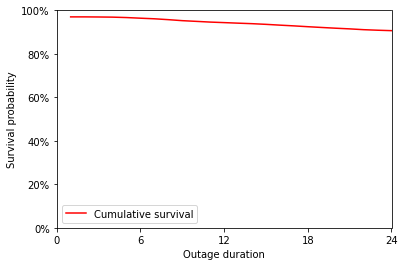

In [33]:
plt.plot(outage_durations, cum_survival, linestyle='-', label = "Cumulative survival", color = "red")
plt.xlabel("Outage duration")
plt.ylabel("Survival probability")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylim([0,1])
plt.xlim([1,max_duration])
time_list =   [120, 48, 24,  12, 8]
time_ticks = [12,   6,  3,   2, 1]

tick_mark_step = 24
for i in range(len(time_list)):
    if max_duration < time_list[i]:
        tick_mark_step = time_ticks[i]

plt.xticks(range(0, max_duration+1, tick_mark_step))
plt.legend()
plt.show()

### Generator added

In [34]:
cum_survival = erp_add_gen_outputs["outputs"]["mean_cumulative_survival_by_duration"]
final_survival_by_start = erp_add_gen_outputs["outputs"]["cumulative_survival_final_time_step"]
max_duration = len(cum_survival)
outage_durations = range(1, max_duration + 1)

### Plot marginal and cumulative survival on same plot vs outage duration

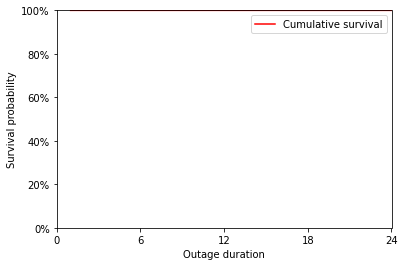

In [35]:
plt.plot(outage_durations, cum_survival, linestyle='-', label = "Cumulative survival", color = "red")
plt.xlabel("Outage duration")
plt.ylabel("Survival probability")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylim([0,1])
plt.xlim([1,max_duration])
time_list =   [120, 48, 24,  12, 8]
time_ticks = [12,   6,  3,   2, 1]

tick_mark_step = 24
for i in range(len(time_list)):
    if max_duration < time_list[i]:
        tick_mark_step = time_ticks[i]

plt.xticks(range(0, max_duration+1, tick_mark_step))
plt.legend()
plt.show()

## Force in modified sizes and rerun REopt

In [37]:
reopt_post_revised = reopt_post_initial
reopt_post_revised["Generator"]["min_kw"] = post_erp_add_gen["Generator"]["num_generators"]*post_erp_add_gen["Generator"]["size_kw"]
reopt_post_revised["Generator"]["max_kw"] = post_erp_add_gen["Generator"]["num_generators"]*post_erp_add_gen["Generator"]["size_kw"]
reopt_post_revised["PV"]["min_kw"] = reopt_initial_outputs["outputs"]["PV"]["size_kw"]
reopt_post_revised["PV"]["max_kw"] = reopt_initial_outputs["outputs"]["PV"]["size_kw"]
reopt_post_revised["ElectricStorage"]["min_kw"] = reopt_initial_outputs["outputs"]["ElectricStorage"]["size_kw"]
reopt_post_revised["ElectricStorage"]["max_kw"] = reopt_initial_outputs["outputs"]["ElectricStorage"]["size_kw"]
reopt_post_revised["ElectricStorage"]["min_kwh"] = reopt_initial_outputs["outputs"]["ElectricStorage"]["size_kwh"]
reopt_post_revised["ElectricStorage"]["max_kwh"] = reopt_initial_outputs["outputs"]["ElectricStorage"]["size_kwh"]

In [38]:
reopt_revised_outputs_file_name = "erp_tag5_reopt_results_revised"
reopt_revised_outputs = get_api_results(post=reopt_post_revised, 
                               API_KEY=API_KEY, 
                               api_url=root_url, 
                               results_file=os.path.join(
                                   outputs_path, 
                                   reopt_revised_outputs_file_name+".json"
                               ), 
                               run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/dev/job/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling https://developer.nrel.gov/api/reopt/dev/job/ba4b82f8-f2bc-4560-966d-bc495bf25358/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag5_reopt_results_with_gen.json


### Summarize inital REopt optimization results

In [40]:
with open(os.path.join(outputs_path, reopt_revised_outputs_file_name + '.json'), 'rb') as handle:
    reopt_revised_outputs = json.load(handle)
    summarize_reopt_results(reopt_post_revised, reopt_revised_outputs)

LCC ($) =  14285028.7681
Capital Cost, Net ($) =  7648745.9036
PV size_kw  =  4049.6685
ElectricStorage size_kw  =  1001.21
ElectricStorage size_kwh  =  7418.92
Generator size_kw  =  3200.0
